# Content and Objectives

- Show effects of diversity combining
- channel is assumed to be slow flat, i.e.: $$R_i= H_i \cdot X+Z_i, \quad Z_i\sim\mathcal{CN}(0,\sigma_Y^2)$$


# Import

In [1]:
# importing
import numpy as np
from scipy import stats, special

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

# Simulation of BER of BPSK in AWGN and Rayleigh

+ We already had that for 4-QAM and are looking at BPSK first
+ Just for comparison and, maybe, one additional insight

+ To this end, the simulation also determines the ber when inverting the channel by applying
$$\tilde{r}=\frac{1}{h}r$$

### parameters

In [3]:
# constellation first
constellation = [ -1,  1]
# Eb/N0
EbN0_db_min = 0
EbN0_db_max = 30
EbN0_db_step = 3

# initialize Eb/N0 array
EbN0_db_range = np.arange( EbN0_db_min, EbN0_db_max, EbN0_db_step )
EbN0_range = 10**( EbN0_db_range / 10 )
sigma2 = 1 / ( 2 * EbN0_range )

# max. numbers of errors and/or symbols
max_errors = int( 1e2 )
max_syms = int( 1e5 )

### simulation

In [4]:
###
# initialize BER arrays 

# theoretical ber for bpsk as on slides
ber_bpsk = np.zeros_like( EbN0_db_range, dtype=float )     
ber_bpsk_theo = 1 - stats.norm.cdf( np.sqrt( 2 * EbN0_range ) )
    
# ber in fading channel    
ber_fading = np.zeros_like( EbN0_db_range, dtype=float ) 
ber_fading_theo = 1 / ( 4 * 10**(EbN0_db_range / 10 ) )

# ber when applying channel inversion
ber_inverted = np.zeros_like( EbN0_db_range, dtype=float )  


###
# loop for snr
for ind_snr, val_snr in enumerate( EbN0_range ):

    # initialize error counter
    num_errors_bpsk = 0
    num_errors_fading = 0
    num_errors_inverted = 0
    
    num_syms = 0

    # get noise variance
    sigma2 = 1. / ( val_snr )  

    # loop for errors
    while ( num_errors_bpsk < max_errors and num_syms < max_syms ):

        # generate data and modulate by look-up
        d = np.random.randint( 0, 2)
        s = constellation[ d ] 

        # generate noise
        noise = np.sqrt( sigma2 / 2 ) * ( np.random.randn() + 1j * np.random.randn() )
        
        
        ###
        # apply different channels
        
        # bpsk without fading
        r_bpsk = s + noise            
        
        # bpsk with slow flat fading
        h = 1/np.sqrt(2) * ( np.random.randn() + 1j * np.random.randn() )
        r_flat = h * s + noise

        
        ### receiver
        # matched filter and inverting channel
        
        # mf and channel inversion
        y_mf = np.conjugate( h / np.abs(h) )* r_flat        
        y_inv = r_flat / h
        
        # demodulate symbols
        d_est_bpsk = int( np.real( r_bpsk ) > 0 )        
        d_est_flat = int( np.real( y_mf ) > 0 )
        d_est_inv = int( np.real( y_inv ) > 0 )
        
        
        ###
        # count errors
        num_errors_bpsk += int( d_est_bpsk != d )
        num_errors_fading += int( d_est_flat != d )
        num_errors_inverted += int( d_est_inv != d )

        # increase counter for symbols
        num_syms += 1


    # ber by relative amount of errors
    ber_bpsk[ ind_snr ] = num_errors_bpsk / num_syms
    ber_fading[ ind_snr ] = num_errors_fading / ( num_syms * 1.0 )   
    ber_inverted[ ind_snr ] = num_errors_inverted / ( num_syms * 1.0 )
    
    # show progress if you like to
    print('Done: SNR = {} dB'.format( 10*np.log10(val_snr) ) )

Done: SNR = 0.0 dB
Done: SNR = 3.0 dB
Done: SNR = 6.0 dB
Done: SNR = 9.0 dB
Done: SNR = 12.0 dB
Done: SNR = 15.0 dB
Done: SNR = 18.0 dB
Done: SNR = 21.0 dB
Done: SNR = 24.0 dB
Done: SNR = 27.0 dB


### plotting 

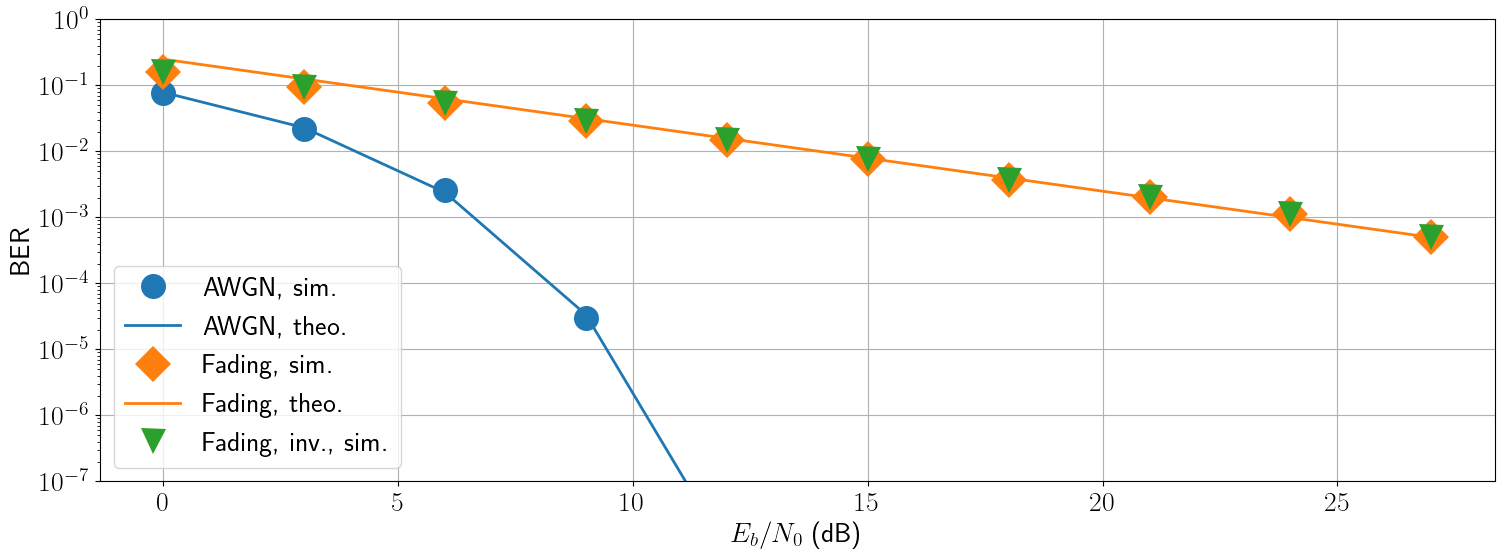

In [5]:
# plot bpsk results using identical colors for theory and simulation
ax_sim = plt.plot( EbN0_db_range, ber_bpsk, marker = 'o', mew=4, ms=18, markeredgecolor = 'none', linestyle='None', label='AWGN, sim.' )            
color_sim = ax_sim[0].get_color()     
plt.plot(EbN0_db_range, ber_bpsk_theo, linewidth = 2.0, color = color_sim, label='AWGN, theo.')  


# plot slow flat results using identical colors for theory and simulation
ax_sim = plt.plot( EbN0_db_range, ber_fading , marker = 'D', mew=4, ms=18, markeredgecolor = 'none', linestyle='None', label = 'Fading, sim.' )
color_sim = ax_sim[0].get_color()     
plt.plot(EbN0_db_range, ber_fading_theo, linewidth = 2.0, color = color_sim, label='Fading, theo.')  


# plot ber when using channel inversion
ax_sim = plt.plot( EbN0_db_range, ber_inverted , marker = 'v', mew=4, ms=18, markeredgecolor = 'none', linestyle='None', label = 'Fading, inv., sim.' )

plt.yscale('log')
plt.grid(True)
plt.legend(loc='lower left') 

plt.ylim( (1e-7, 1) )

plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('BER')

plt.show()

# Show Effects of Diversity to Constellation Diagram

+ 4-QAM is being transmitted via 3 different Rayleigh channels

### parameters

In [6]:
# EbN0 to be used for the simulation
Es_N0_dB = 10

# numbers in diversity realizations 
N_diversity = 4

# number of realizations for every point
N_real = 20

# 4- QAM
constellation = 1/np.sqrt(2) * np.array( [ 1+1j, 1-1j, -1-1j, -1+1j ] )

### simulation of symbols

In [7]:
# generate channel and faded noisy signal
h = 1./np.sqrt( 2 ) * ( np.random.randn( N_diversity ) + 1j * np.random.randn( N_diversity ) )

# define constellation and sample symbols
symbols = np.random.choice( constellation, size=N_real)

# sample noise
sigma2 = 10**( - Es_N0_dB / 10 )

# get different values of y, depending on the according channel realization
y = np.zeros( ( N_real, N_diversity ), dtype=complex )

for _n in range( N_diversity ):
    noise = np.sqrt( sigma2 / 2 ) * ( np.random.randn( N_real ) + 1j * np.random.randn( N_real ) )

    y[ :, _n ] = h[ _n ] * symbols + noise 



### plotting

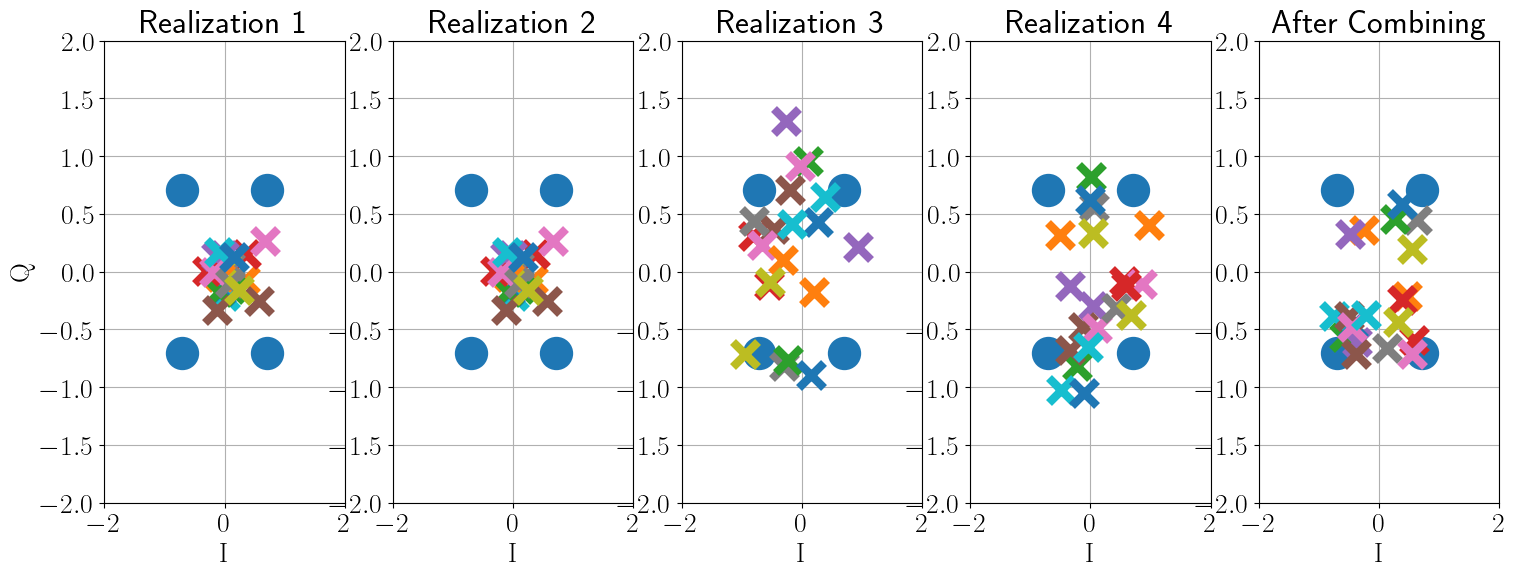

In [8]:
# plotting
fig, axes = plt.subplots( 1, N_diversity + 1 )


plt.subplot(1, N_diversity + 1, 1)
plt.plot( np.real( constellation ), np.imag( constellation ) , 'o', ms=18, mew=6)
for _n_real in range( N_real ):
    plt.plot( np.real( y[ _n_real, 1 ] ), np.imag( y[ _n_real, 1 ] ) , 'x', ms=18, mew=6)
plt.xlim( (-2, 2 )); plt.ylim( (-2, 2 ))
plt.grid(True); plt.xlabel('$\\mathrm{I}$');  
plt.title('Realization {}'.format(1) )
plt.ylabel('$\\mathrm{Q}$')#


for _n_div in range( 2, N_diversity + 1):
    plt.subplot( 1, N_diversity + 1, _n_div )

    plt.plot( np.real( constellation ), np.imag( constellation ) , 'o', ms=18, mew=6)
    for _n_real in range( N_real ):   
        plt.plot( np.real( y[ _n_real, _n_div -1 ] ), np.imag( y[ _n_real, _n_div -1 ] ) , 'x', ms=18, mew=6)
    plt.xlim( (-2, 2 )); plt.ylim( (-2, 2 ))
    plt.grid(True); plt.xlabel('$\\mathrm{I}$');  
    plt.title('Realization {}'.format(_n_div) )



plt.subplot( 1, N_diversity + 1, N_diversity + 1 )
plt.plot( np.real( constellation ), np.imag( constellation ) , 'o', ms=18, mew=6)
plt.xlim( (-2, 2 )); plt.ylim( (-2, 2 ))
plt.grid(True); plt.xlabel('$\\mathrm{I}$');  

h_MRC = np.conjugate( h ) / np.abs( h )
for _n_real in range( N_real ):

    y_MRC = np.array( [ np.inner( h_MRC, y[ _n_real, :] ) ] )

    plt.plot( np.real( y_MRC )/3, np.imag( y_MRC )/3 , 'x', ms=18, mew=6)
    plt.title('After Combining')

plt.show()

# Show that the SNR Improvements are as given in the Lecture

### parameters

In [9]:
# find constellation points in the IQ plane
constellation = [-1, 1]
M = 2

# EbN0 to be used for the simulation
EbN0_dB = 10

# get cariance of the noise
sigma2 = 10**(-EbN0_dB/10)

# numbers in diversity realizations 
N_diversity = np.arange(1, 21, 1)

# combining methods
comb_method = ['SC', 'EGC', 'MRC']

# initialize empty matrix for storing snrs after combining, depending on method and diversity
snr_comb = np.zeros( (len(comb_method), len(N_diversity)))


# number of realizations for every point
N_real = 1e3

### function for getting combining coefficients

In [10]:
########################
# combining function
########################
def my_combining( h, method ):
    """ applies the specified combining method to a vector of realizations
    
    REMARK: perfect CSIR is assumed
    
    IN: vector h of CSIR, method to be applied as string
    
    OUT: coefficients for the combining method 
    """
    
    a = np.zeros(len(h), dtype=complex)      
    
    # switch according to requested combining scheme
    if method=='SC':
        # find index with max. channel coefficient 
        ind = np.where( np.abs(h)**2 == np.max(np.abs(h)**2) )
        a[ ind ] = 1
        
    elif method=='EGC':
        # find angles of channel coefficients and assign to a
        a = np.exp( - 1j * np.angle( h ) )
        
    elif method=='MRC':
        # find snrs and weight according to them
        a = h.conj() / sigma2
        
    else:
        raise NameError('No feasible combining method given!')
        
    # return values being normalited to norm 1
    return a / np.linalg.norm(a)

### simulation

In [11]:
# loop for combining method
for n_comb, comb_meth in enumerate( comb_method ):

    # loop for snr
    for ind_div, n_div in enumerate( N_diversity ):

        # initialize power values            
        P_x_comb = 0
        P_n_comb = 0

        # loop for realizations
        for _n in np.arange(N_real):

            # generate data symbols and build tx symbol
            d = np.random.randint(0, M)
            s = constellation[ d ]

            # generate channel and faded noisy signal
            h = 1./np.sqrt( 2 ) * ( np.random.normal( size=(n_div,) ) + 1j * np.random.normal( size=(n_div,) ) )
            noise = np.sqrt( sigma2/2 ) * ( np.random.randn( len(h) ) + 1j * np.random.randn( len(h) ) )

            # apply fading and noise
            y_fade = h * s 
            r = y_fade + noise


            # apply combining method by first getting weights, combining and measuring/updating according power values
            a_comb = my_combining(h, comb_meth )

            r_comb = 1 / n_div * np.dot(a_comb, r)
            noise_comb = 1 / n_div *  np.dot(a_comb, noise)

            P_x_comb += np.linalg.norm( r_comb - noise_comb )**2
            P_n_comb += np.linalg.norm( noise_comb )**2  

        snr_comb[ n_comb, ind_div ] = P_x_comb / P_n_comb * 10**( -EbN0_dB/10 )

### plotting

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/gl/klr5r63x1n7gc51klm74k_900000gn/T/ipykernel_8491/2746937047.py:16: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathrm{SNR}_{\mathrm{comb.}}/\mathrm{SNR}_{\mathrm{Ray.}}$')


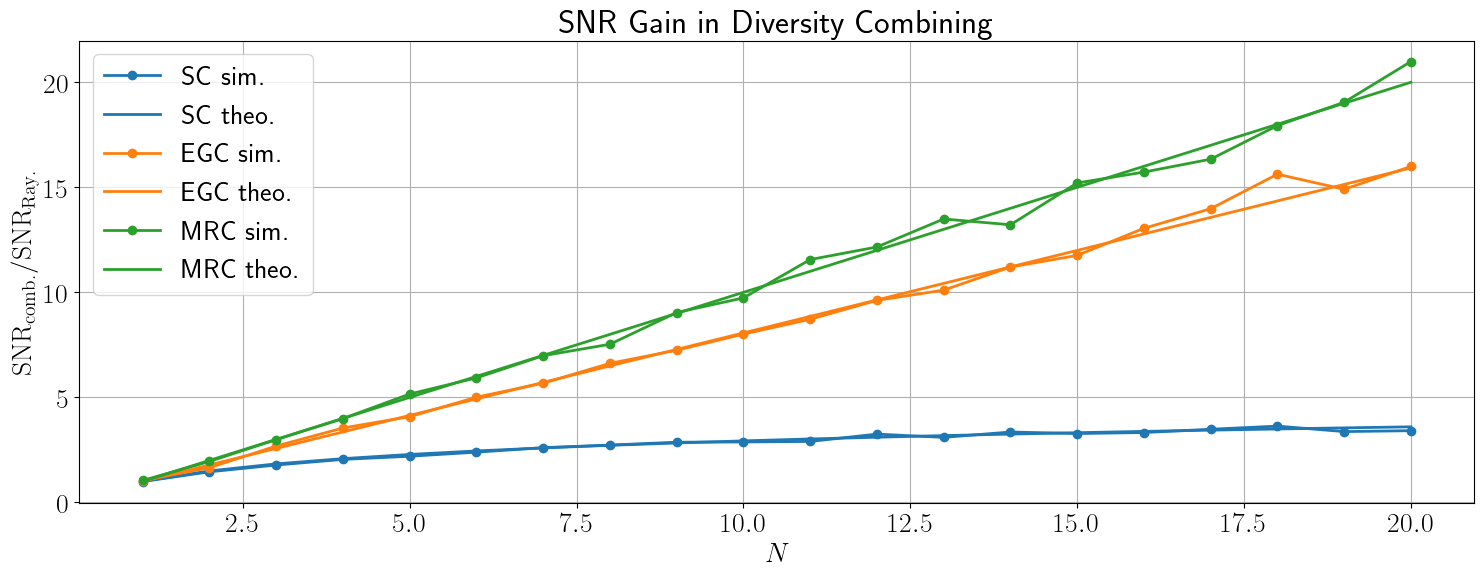

In [12]:
# theoretical values
snr_theo = np.zeros( (len(comb_method), len(N_diversity)))
snr_theo[0,:] = np.cumsum( 1.0 / N_diversity )
snr_theo[1,:] = 1 + ( N_diversity - 1 ) * np.pi/4
snr_theo[2,:] = N_diversity

# plotting
for _c, c in enumerate(comb_method):
    ax_sim = plt.plot( N_diversity, snr_comb[_c, :], '-o', label = c+' sim.', linewidth = 2.0)

    color_sim = ax_sim[0].get_color()            
    plt.plot( N_diversity, snr_theo[_c, :], color = color_sim, label = c+' theo.', linewidth = 2.0)

plt.grid(True)
plt.xlabel('$N$')
plt.ylabel('$\mathrm{SNR}_{\mathrm{comb.}}/\mathrm{SNR}_{\mathrm{Ray.}}$')
plt.title('SNR Gain in Diversity Combining')
plt.legend(loc='upper left')
plt.show()

# Simulation of Error Rates

+ NOTE: this time it is, again, using BPSK

### parameters

In [13]:
# switch to normalize Tx power if necessary, 
# e.g., to have identical E_b when applying repetition coding    
div_is_normalized = 1


# esN0 to be used for the simulation
EbN0_db_min = 0
EbN0_db_max = 14    
EbN0_db_step = 2

EbN0_db_range = np.arange( EbN0_db_min, EbN0_db_max + EbN0_db_step, EbN0_db_step)
EbN0_range = 10**( np.array(EbN0_db_range)/10. )


# parameters limiting simulation time
max_errors = 1e2
max_syms = 1e5


# diversity realizations 
# comb_method has to have same length or only one element then being the same for all N_divs
# if N_div is empty no combining will be performed

N_values = [ 2, 4, 8, 12]
comb_methods = ['MRC']


# get combinations of number of diversity and methods
N_div = N_values * len( comb_methods )
combining_method = sorted( comb_methods * len( N_values ) )

### simulation of awgn

In [14]:
# simulate fading wo. combining first

# initialize arrays for storing simulation results
ber_fading = np.zeros( len(EbN0_db_range) )
ber_awgn = np.zeros( len(EbN0_db_range) )

# loop for snr
for n_snr, val_snr_dB in enumerate( EbN0_db_range ):

    val_snr = 10**( val_snr_dB/10. )
    sigma2 = 1. / val_snr

    # reset counters
    num_errors_awgn = 0
    num_errors_fading = 0 
    num_syms = 0

    # loop for errors
    while ( num_syms < max_syms and num_errors_awgn < max_errors ):

        # generate data symbols and build tx symbol
        d = np.random.randint(0, 2)
        s = 1 - 2 * d

        ### Estimate behavior without diversity
        ### assuming perfect CSIR

        # generate channel and faded noisy signal
        # note that the channel is always complex-valued since a phase shift may still occurr
        h = 1./np.sqrt(2) * (np.random.normal() + 1j*np.random.normal() )

        noise = np.sqrt( sigma2/ 2 ) * ( np.random.normal() + 1j*np.random.normal() )

        # apply channel and noise
        r_awgn = s + noise            
        r_fading = h * s + noise 

        #####
        # demodulate
        d_est_awgn = int( r_awgn < 0 ) 
        d_est_fading = int( np.conjugate(h) / np.abs(h) * r_fading < 0 )

        if not np.isclose( d_est_awgn, d ):
                num_errors_awgn += 1

        if not np.isclose( d_est_fading, d ):
                num_errors_fading += 1

        num_syms += 1        

    # ber
    ber_awgn[ n_snr ] = num_errors_awgn / ( num_syms * 1.0 ) 
    ber_fading[ n_snr ] = num_errors_fading / ( num_syms * 1.0 ) 

    # activate if you loke to monitor progress
    print('Eb/N0 (dB) = {:2.2f}'.format(val_snr_dB))

Eb/N0 (dB) = 0.00
Eb/N0 (dB) = 2.00
Eb/N0 (dB) = 4.00
Eb/N0 (dB) = 6.00
Eb/N0 (dB) = 8.00
Eb/N0 (dB) = 10.00
Eb/N0 (dB) = 12.00
Eb/N0 (dB) = 14.00


### now simulation with combining

In [15]:
# now results for combining 

# initialize arrays for storing simulation results
ber_comb = np.zeros( ( len(combining_method), len(EbN0_db_range) ) )


# loop for snr
for n_snr, val_snr_dB in enumerate( EbN0_db_range ):

    val_snr = 10**( val_snr_dB /10. )
    sigma2 = 1./ val_snr

    ### generate multiple observations and apply diversity
    ### assuming perfect CSIR          
    for k in np.arange( len(combining_method) ):    

        num_errors_comb = 0
        num_syms_comb = 0    

        # loop for errors        
        while ( num_syms_comb < max_syms and num_errors_comb < max_errors):

            # generate data symbols and build tx symbol
            d = np.random.randint( 0, 2)
            s = 1 -  2 * d

            if div_is_normalized:
                s_div = s / np.sqrt( N_div[k])
            else:
                s_div = s


            # generate channel and faded noisy signal
            # note that the channel is always complex-valued since a phase shift may still occurr
            h_div = 1./np.sqrt(2) * (np.random.normal( size = N_div[k] ) + 1j*np.random.normal( size = N_div[k] ) )                

            noise_div = np.sqrt( sigma2 / 2 ) * ( np.random.normal( size = N_div[k] ) + 1j*np.random.normal( size = N_div[k] ) )

            # apply channel and noise
            r_div = h_div * s_div + noise_div     

            # apply combining method
            #a_comb = my_combining_old(h, comb_method[k] )
            a_comb = my_combining( h_div, combining_method[k] )

            r_comb = np.dot(a_comb, r_div)

            # demodulate
            d_est_comb = int( r_comb < 0 )

            if not np.isclose( d_est_comb, d ):
                    num_errors_comb += 1

            num_syms_comb += 1

        # ber                
        ber_comb[ k, n_snr ] = num_errors_comb / (num_syms_comb * 1.0 )

    # activate if you like to monitor progress
    print('Eb/N0 (dB) = {:2.2f}'.format(val_snr_dB))

Eb/N0 (dB) = 0.00
Eb/N0 (dB) = 2.00
Eb/N0 (dB) = 4.00
Eb/N0 (dB) = 6.00
Eb/N0 (dB) = 8.00
Eb/N0 (dB) = 10.00
Eb/N0 (dB) = 12.00
Eb/N0 (dB) = 14.00


### plotting

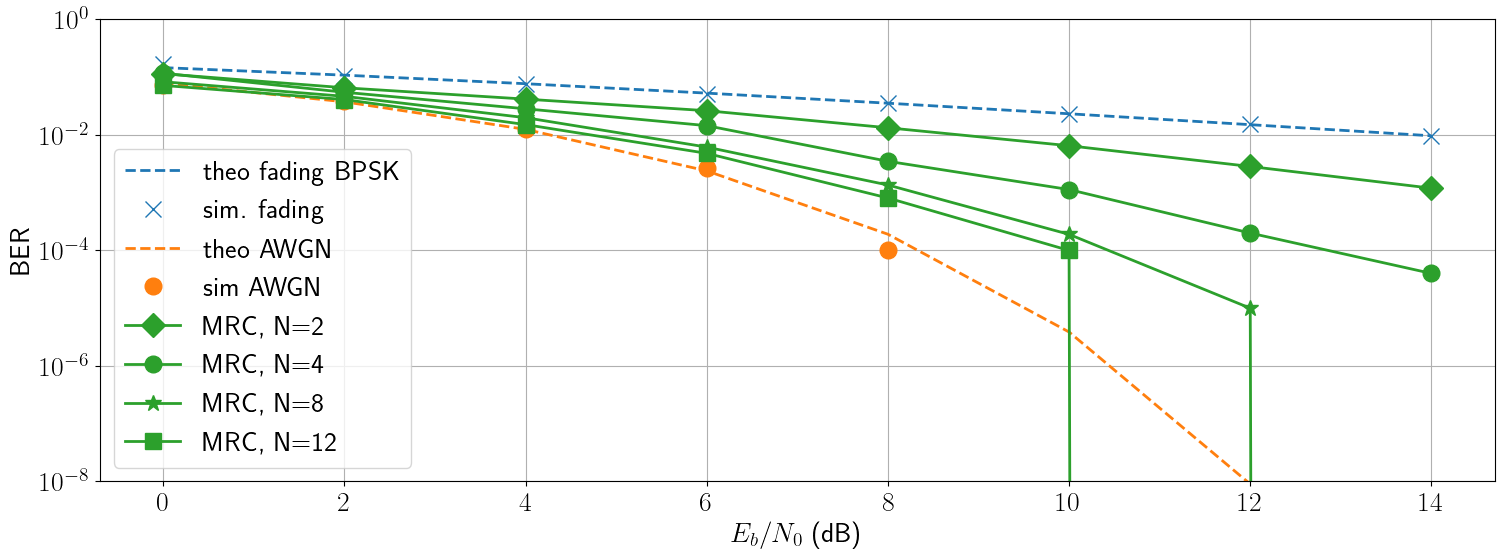

In [16]:
# theoretical values
ber_theo = 1 - stats.norm.cdf( np.sqrt( 2 * EbN0_range ))
ber_fade_theo = 1./2. * ( 1- np.sqrt( EbN0_range /(1+EbN0_range)))

# theoretical result of [Tse] for MRC und N=4 for comparison/checks
N = 4
ber_tse_mrc_N = special.binom(2*N-1, N) * 1 / ( 4 * EbN0_range)**N

# plotting
plt.figure()

ax_fading = plt.plot(EbN0_db_range, ber_fade_theo, '--', label='theo fading BPSK', linewidth = 2.0 )
color_fading = ax_fading[0].get_color()
plt.plot(EbN0_db_range, ber_fading, 'x', ms=12, label="sim. fading", color=color_fading, linewidth = 2.0 )  

ax_awgn = plt.plot(EbN0_db_range, ber_theo, '--', label="theo AWGN", linewidth = 2.0 )  
color_awgn = ax_awgn[0].get_color()
plt.plot(EbN0_db_range, ber_awgn, 'o', ms=12, label="sim AWGN", color=color_awgn, linewidth = 2.0 )  


# loop across markes 
markers = [ 'D', 'o', '*', 's', 'v', 'p' ]

# combining methods have identical colors but alternating markers
for k in np.arange(len(combining_method)):

    if k % len(N_values) == 0:   
        mark_ind = 0
        ax_comb = plt.plot(EbN0_db_range, ber_comb[k, :], label=combining_method[k]+", N="+str(N_div[k]), linewidth = 2.0, marker = markers[ mark_ind ], markersize = 12 )      
        color_comb = ax_comb[0].get_color()                

    else:                
        mark_ind += 1
        plt.plot(EbN0_db_range, ber_comb[k, :], label=combining_method[k]+", N="+str(N_div[k]), linewidth = 2.0, color = color_comb,  marker = markers[ mark_ind % len(markers)], markersize = 12 )


plt.yscale('log')
plt.grid(True)
plt.legend(loc='lower left') 

plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('BER')
plt.ylim( ymin=1e-8, ymax=1e0 )
plt.show()
    